In [54]:
import numpy as np
import pandas as pd
from music21 import *

In [10]:
sr = 10   # down sampling rate from MIDI to time axis

# Load score (xml) data

In [191]:
path="data/pedb2_v0.0.1.b/"
targetxml="bac-wtc101-p-a-p1/bac-wtc101-p.xml"
#targetmid="bac-wtc101-p-a-p1/bac-wtc101-p-a-p1.mid"

#piecemid=converter.parse(path+targetmid)
piecexml=converter.parse(path+targetxml)
piece=piecexml

for i, p in enumerate(range(len(piecexml))):
    print(i, piece[p])
print("# of measures:",len(piece[4]))

0 <music21.text.TextBox 'Johann Seb...'>
1 <music21.text.TextBox 'ISBN4-276-...'>
2 <music21.text.TextBox 'Das Wohlte...'>
3 <music21.metadata.Metadata object at 0x134dda170>
4 <music21.stream.PartStaff P1-Staff1>
5 <music21.stream.PartStaff P1-Staff2>
6 <music21.layout.ScoreLayout>
7 <music21.layout.StaffGroup <music21.stream.PartStaff P1-Staff1><music21.stream.PartStaff P1-Staff2>>
# of measures: 36


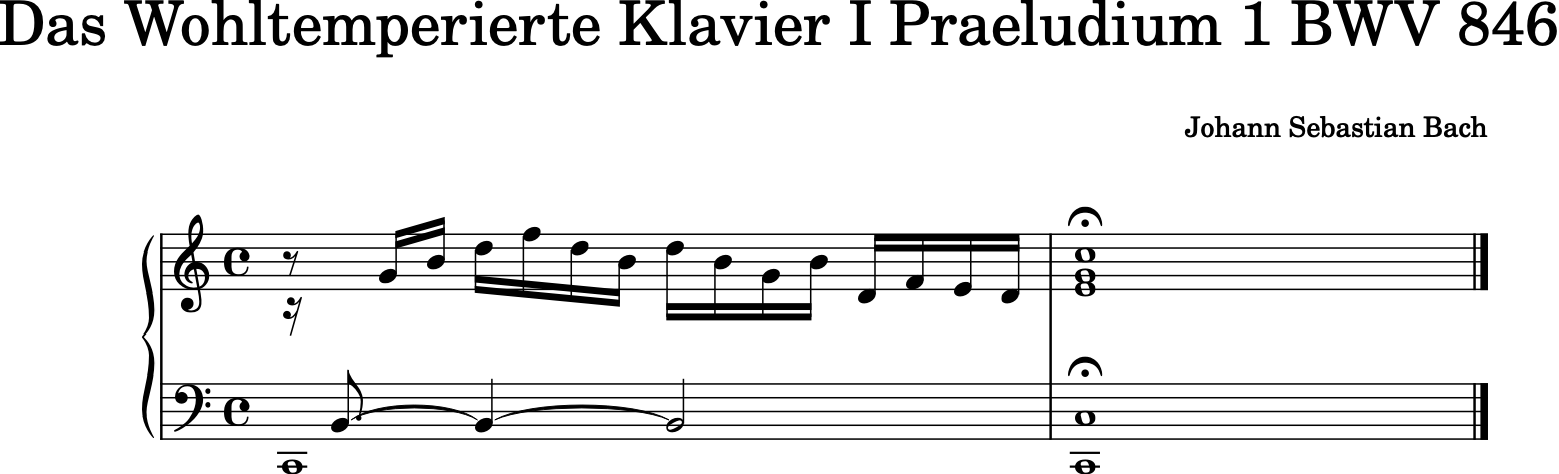

In [193]:
piece.measures(34,35).show()

# Load performance data (csv) and extract note_on

In [153]:
path="outputs/"
#target="bac-inv001-o-p1.csv"
target="bac-wtc101-p-a-p1.csv"
df=pd.read_csv(path+target)

# note_onでvelocityが0になっているものはnote_offにする。
print(df[(df["type"] == "note_on") & (df["velocity"] == 0)]['type'])
df.loc[ (df["type"] == "note_on") & (df["velocity"] == 0), 'type'] = 'note_off'

# extract note_on
note_on=df[df['type']=='note_on'][['time_counter','note','note_name','velocity']]

#note_on=note_on.reindex(index=range(len(note_on)))
display(note_on[:5])

1082    note_on
Name: type, dtype: object


,time_counter,note,note_name,velocity
73,49825,60.0,C4,38.0
93,57007,64.0,E4,17.0
104,61710,67.0,G4,28.0
108,65704,72.0,C5,38.0
110,68968,76.0,E5,37.0


16音ごとにビート番号(1,2,3,...16)をつける

In [205]:
note_on.index=range(len(note_on))

note_on["beat"]=note_on.index%16
display(note_on[:5])
display(note_on[16*33:])

,time_counter,note,note_name,velocity,beat
0,49825,60.0,C4,38.0,0
1,57007,64.0,E4,17.0,1
2,61710,67.0,G4,28.0,2
3,65704,72.0,C5,38.0,3
4,68968,76.0,E5,37.0,4


,time_counter,note,note_name,velocity,beat
528,2072085,36.0,C2,39.0,0
529,2078805,47.0,B2,36.0,1
530,2084449,67.0,G4,34.0,2
531,2089327,71.0,B4,49.0,3
532,2093915,74.0,D5,45.0,4
533,2098810,77.0,F5,59.0,5
534,2104053,74.0,D5,57.0,6
535,2108392,71.0,B4,55.0,7
536,2114997,74.0,D5,50.0,8
537,2121390,71.0,B4,43.0,9


## get interval between notes
### get interval between neighboring notes

In [206]:
# between neighboring notes
tmp_duration=pd.DataFrame(note_on.time_counter.diff().shift(-1))
tmp_duration=tmp_duration.rename(columns={"time_counter":"duration"})
df_duration=pd.concat([note_on,tmp_duration], axis=1)
df_duration[-20:]

df_duration=df_duration[:-10] #最後の5音は和音。その直前にトリルあり。最後の10音は削除

## get interval between notes of the same beat

最後の5音は和音。その直前にトリルあり。最後の10音は削除

In [207]:
tmp_duration=pd.DataFrame(note_on.time_counter.diff(4).shift(-4))
tmp_duration=tmp_duration.rename(columns={"time_counter":"duration"})
df_duration4=pd.concat([note_on,tmp_duration], axis=1)
df_duration4.index=range(len(df_duration4))

df_duration4=df_duration4[:-10] #最後の5音は和音。その直前にトリルあり。最後の10音は削除

[between neighboring notes]
  mean= 3870.240295748614
  std= 536.766582765028
  std/mean= 0.13869076381501583
[between beats]
[between 0st beats]
[between 1st beats]
[between 2st beats]
[between 3st beats]


Text(0, 0.5, 'coefficient of variation')

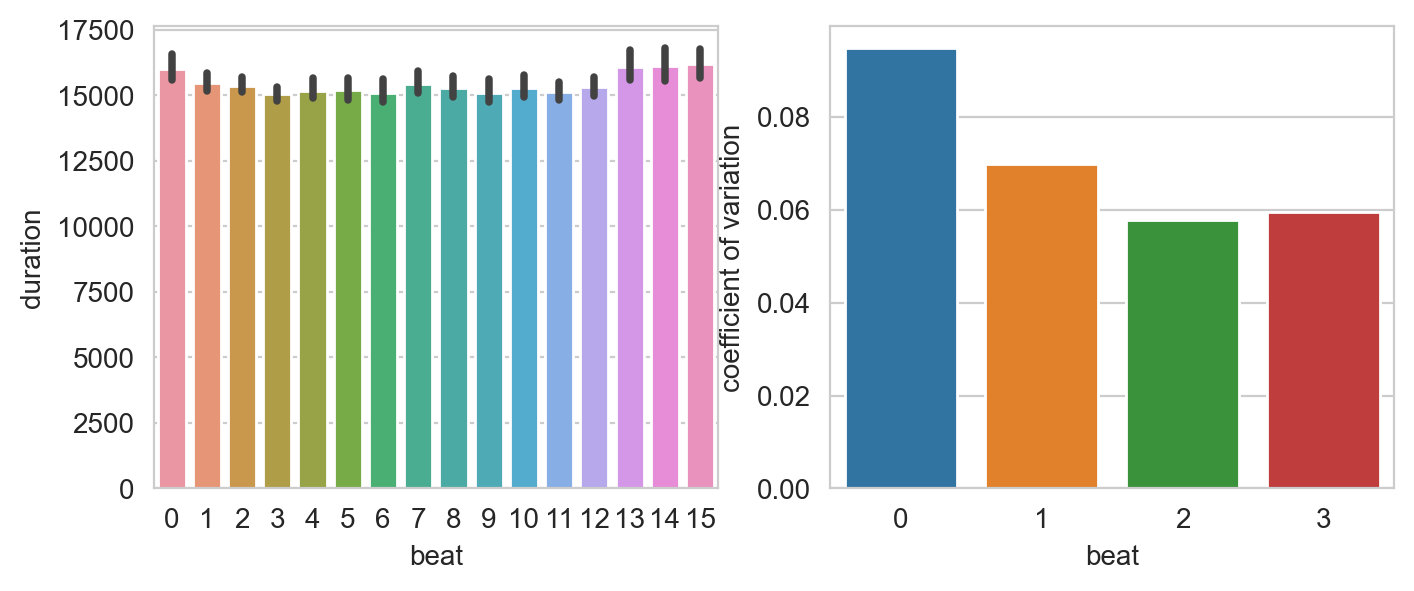

In [210]:
def get_stats(df, verbose=False):
    mean, std = df.mean(), df.std()
    if verbose:
        print("  mean=", mean)
        print("  std=", std)
        print("  std/mean=", std / mean)
    return mean, std, std / mean


print("[between neighboring notes]")
get_stats(df_duration["duration"], verbose=True)

print("[between beats]")
get_stats(df_duration4["duration"])

means = np.empty(4)
stds = np.empty(4)
cov = np.empty(4)  # coefficient of variation (std/mean)
# df_stat=pd.DataFrame([])

for i in range(4):
    print("[between {}st beats]".format(i))
    df = df_duration4[df_duration4["beat"] == i]
    means[i], stds[i], cov[i] = get_stats(df["duration"], verbose=False)

from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# sns.barplot(x=np.arange(4),y=means)
sns.barplot(data=df_duration4, x="beat", y="duration", ax=ax[0])
sns.barplot(x=np.arange(4), y=cov, ax=ax[1])
ax[1].set_xlabel("beat")
ax[1].set_ylabel("coefficient of variation")

Text(0.5, 0, 'beat')

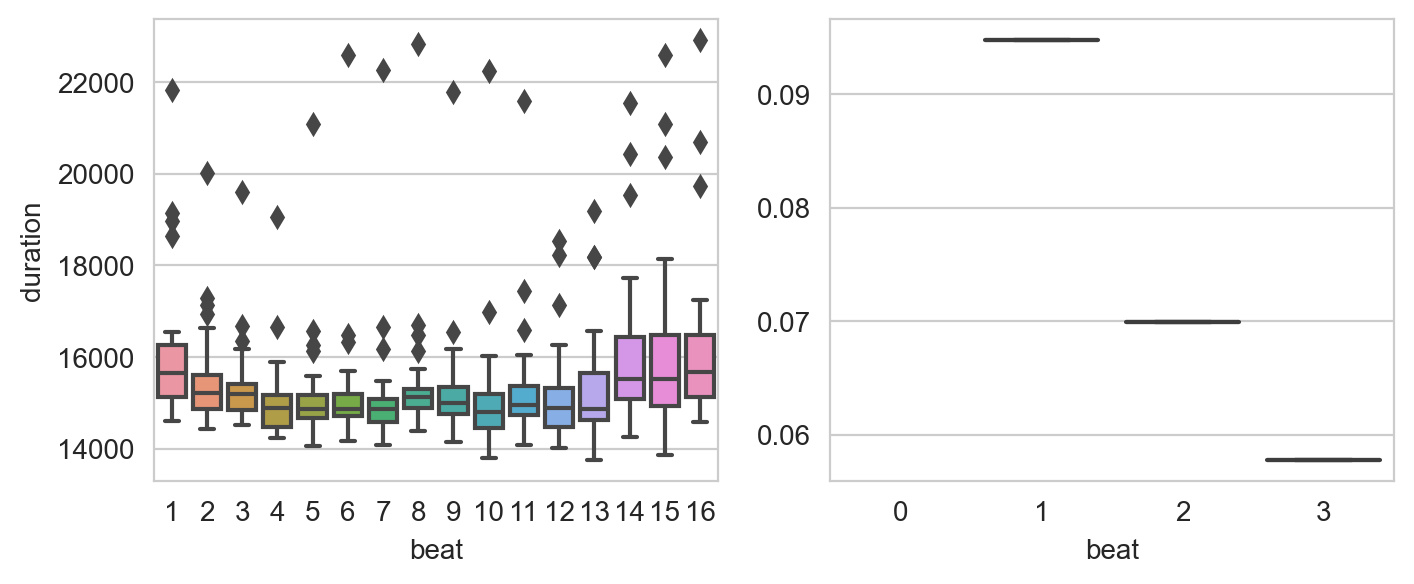

In [203]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
sns.boxplot(data=df_duration4, x="beat", y="duration", ax=ax[0])
sns.boxplot(x=np.arange(4), y=cov, ax=ax[1])
ax[1].set_xlabel("beat")

In [89]:
print(df_duration4[df_duration4["duration"]<13000])
display(df_duration4[230:245])

     time_counter  note note_name  velocity  beat  duration
237        938632  60.0        C4      40.0     1   11289.0
238        942645  67.0        G4      43.0     2   11750.0
239        945755  72.0        C5      51.0     3   12749.0


,time_counter,note,note_name,velocity,beat,duration
230,913153,67.0,G4,45.0,2,14881.0
231,916264,72.0,C5,51.0,3,15168.0
232,920046,52.0,E3,51.0,0,15034.0
233,923924,55.0,G3,37.0,1,14708.0
234,928034,60.0,C4,41.0,2,14611.0
235,931432,67.0,G4,51.0,3,14323.0
236,935080,72.0,C5,56.0,0,13344.0
237,938632,60.0,C4,40.0,1,11289.0
238,942645,67.0,G4,43.0,2,11750.0
239,945755,72.0,C5,51.0,3,12749.0


## colormaps
https://seaborn.pydata.org/tutorial/color_palettes.html

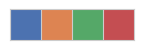

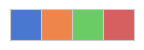

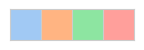

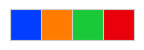

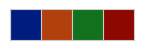

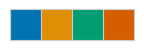

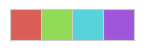

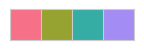

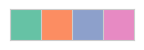

In [49]:
for palette in ['deep', 'muted', 'pastel', 'bright', 'dark', 'colorblind','hls', 'husl', 'Set2']:
    sns.palplot(sns.color_palette(palette, n_colors=4),size=.4, )


Text(0, 0.5, 'velocity')

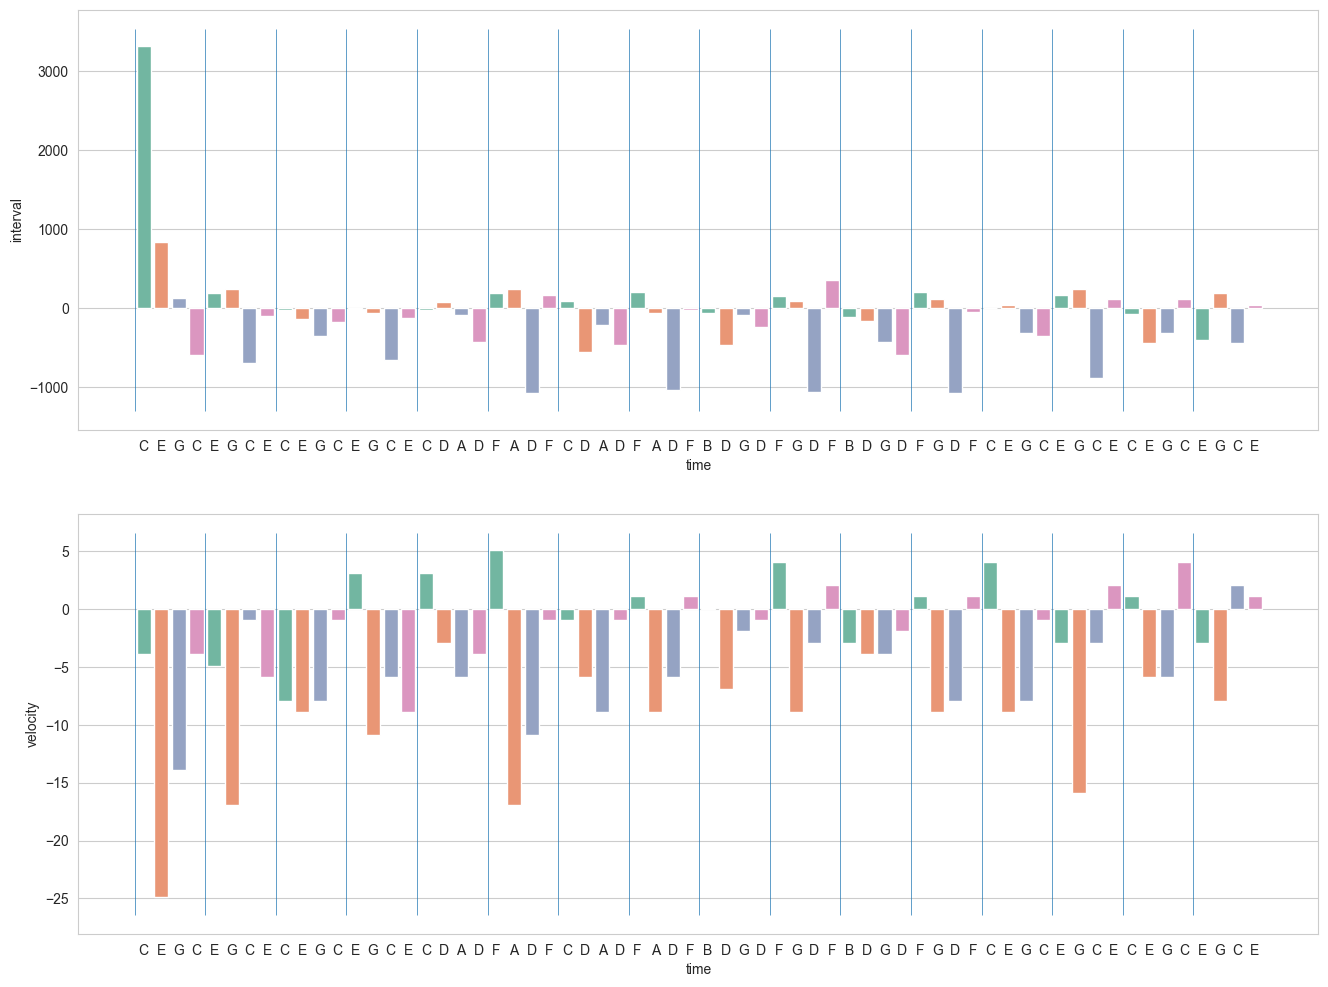

In [50]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# get deviation from the mean
df_duration["Dduration"]=df_duration["duration"]-df_duration["duration"].mean()
df_duration["Dvelocity"]=df_duration["velocity"]-df_duration["velocity"].mean()

# set target
target=df_duration[:64]

# prepare colormap
colors = sns.color_palette(palette, n_colors=4)

# graphics

sns.set_style(style="whitegrid")
fig, ax=plt.subplots(nrows=2, ncols=1, figsize=(16,12))

# g1=ax[0].bar(range(len(target["Dduration"])),target["Dduration"])
# g2=ax[1].bar(range(len(target["Dduration"])),target["Dvelocity"])

g1=sns.barplot(data=target, x="time_counter",y="Dduration", palette=colors, ax=ax[0])
g2=sns.barplot(data=target, x="time_counter",y="Dvelocity", palette=colors, ax=ax[1])
grp=[g1,g2]

notes=list(target.note_name)
for g in grp:
    g.set_xlabel("time")
    g.set_xticks(range(len(notes)))
    g.set_xticklabels(notes)
    ymin,ymax=g.get_ylim()
    g.vlines(x=np.arange(0,len(target),4)-0.5,lw=0.5,ymin=ymin, ymax=ymax)

g1.set_ylabel("interval")
g2.set_ylabel("velocity")

## interval vs velocity
### interval[t,t+1] vs velocity[t]

/var/folders/vb/b6q3gnpn06qbf57_pwjr9jfc000136/T/ipykernel_30361/561271496.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=target, x="Dduration", y="Dvelocity", palette=colors)


<AxesSubplot: xlabel='Dduration', ylabel='Dvelocity'>

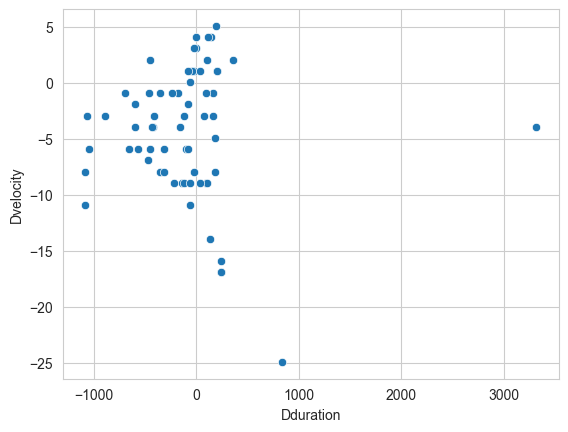

In [51]:
sns.scatterplot(data=target, x="Dduration", y="Dvelocity", palette=colors)

### interval[t,t+1] vs velocity[t+1]

/var/folders/vb/b6q3gnpn06qbf57_pwjr9jfc000136/T/ipykernel_30361/1120865196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target2["Dvelocity"]=target["Dvelocity"].shift(-1)
/var/folders/vb/b6q3gnpn06qbf57_pwjr9jfc000136/T/ipykernel_30361/1120865196.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=target2, x="Dduration", y="Dvelocity", palette=colors)


<AxesSubplot: xlabel='Dduration', ylabel='Dvelocity'>

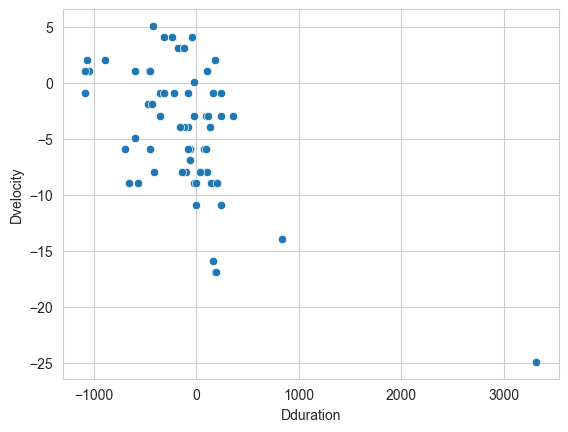

In [52]:
target2=target
target2["Dvelocity"]=target["Dvelocity"].shift(-1)
sns.scatterplot(data=target2, x="Dduration", y="Dvelocity", palette=colors)

## interval between each pulse

In [10]:
help(range)

Help on class range in module builtins:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |